# **Shakespearean Sonnet Generator**


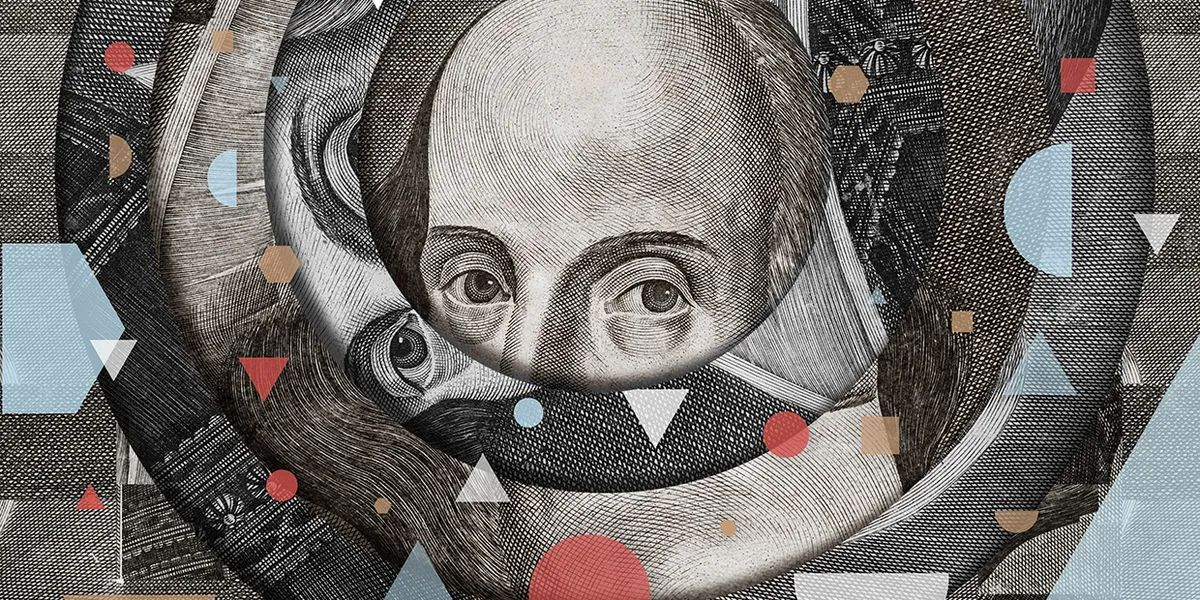

The objective of this project is to develop a Shakespearean sonnets generator using predictive modeling techniques.
With a corpus of 154 authentic Shakesperean sonnets as our foundation, we explore and compare two distinct approaches: word prediction and character prediction. Though there approaces, we aim to generate new sonnets that capture the essence and style of Shakespeare's poetic language.

The word prediction approach focuses on understanding and modeling the relationships between words in the sonnet corpus. By analyzing patterns, semantic connections, and contextual cues, the model generates lines that adhere to the poetic conventions and eloquence characteristic of Shakespearean sonnets.

In contrast, the character prediction approach delves deeper into the intricacies of Shakespearean language by considering individual characters. By recognizing the subtle nuances and linguistic idiosyncrasies of Shakespeare's writing, the model constructs sonnets that exhibit the distinct rhythm, meter, and lyrical quality associated with his works.

Through a comparative analysis of the outputs generated by these two approaches, we aim to assess their effectiveness in producing sonnets that resonate with the Shakespearean aesthetic. Evaluating their poetic quality, adherence to the structural and thematic elements of sonnets, and overall creativity, we seek to determine which approach yields more compelling results.


## Data importation and Library Setup

To begin our project, we first need to import the necessary libraries and load the data. After that, we perform data preparation steps, including removing sonnet titles and empty lines, converting the text to lowercase, and eliminating unwanted characters such as square brackets, tabs, and hyphens. These steps ensure that the corpus is cleaned and formatted appropriately for further analysis and modeling.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [ ]:
pip install pyphen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np
import re
import string
from tensorflow import keras
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk import trigrams
import pyphen
from wordcloud import WordCloud
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
import random


In [ ]:
data = open("sonnets.txt", encoding="utf-8").read()
data = re.sub(r'\n\n[IVXLCDM]+.\n\n', '\n\n', data)
data= data[193:]
data = data.lower()
data=data.replace('[', '').replace(']', '').replace('\t', '').replace('-', '')

## Exploratory Data Analysis



Befor delving into the generation of Shakesperean sonnets, we conduct an exploratory data analysis on the text data we're working with. This serves as a foundation for understanding the characteristics patterns and nuances present in the sonnets corpus. In this section, we will explore various aspects of the text data, such as its structure, vocabulary, and statistical properties. Through visualizations, statistical summaries, and linguistic analyses, we aim to gain insights into the underlying patterns and features that define Shakespearean sonnets.

As first step, we count the number of words and character in the entire corpus:

In [ ]:
# Total Characters
total_characters = len(data)

# Total Words
total_words = len(data.split())
total_unique_words=len(set(data.split()))

print(f"Total Characters: {total_characters}")
print(f"Total Words: {total_words}")
print(f"Total Unique Words: {total_unique_words}")

Total Characters: 94251
Total Words: 17511
Total Unique Words: 4375


We also check for the number of characters per sonnets

Average sonnet length: 610.03 characters


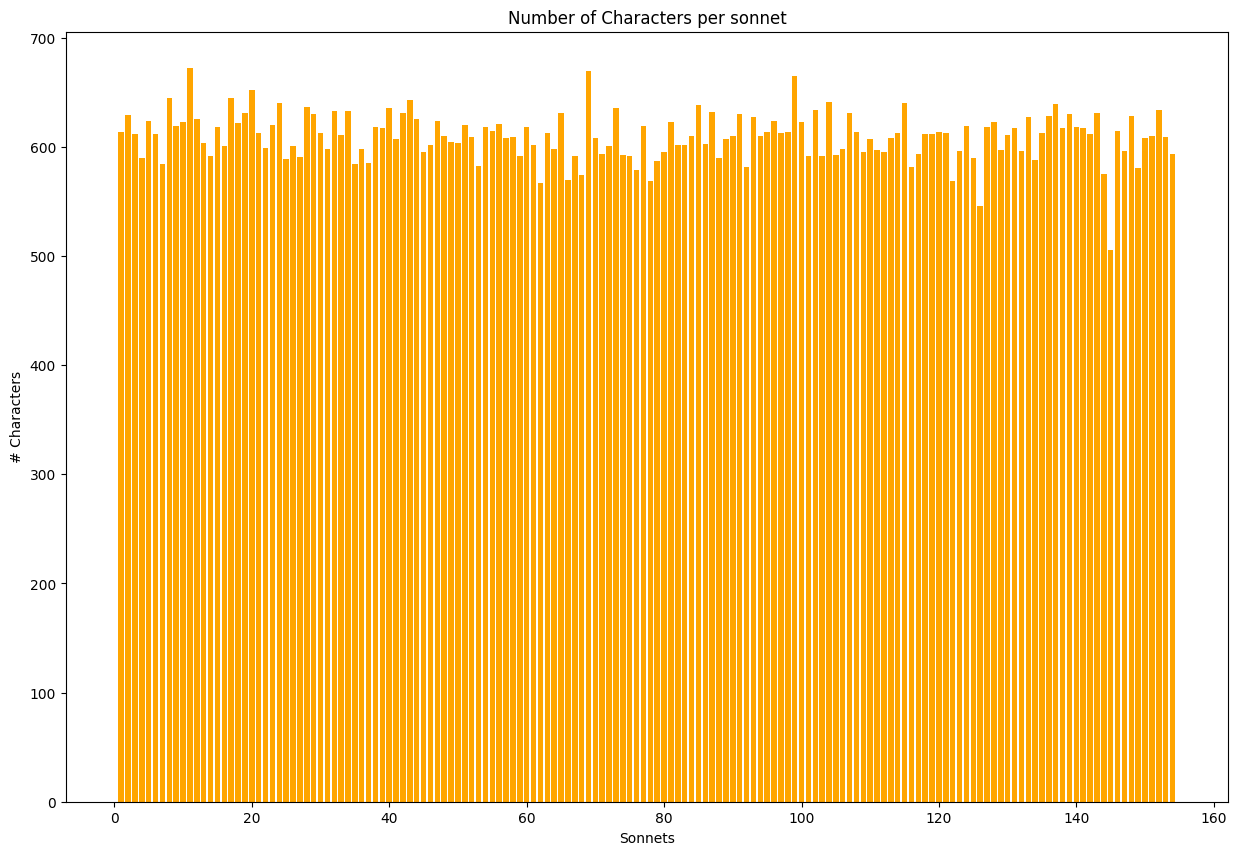

In [ ]:
# Visualize sonnet character length
sonnets = data.split('\n\n')
sonnet_lens = [len(sonnet) for sonnet in sonnets]
print('Average sonnet length: %.2f characters' % np.mean(sonnet_lens))

plt.figure(figsize=(15,10))
plt.bar([i for i in range(1, len(sonnets)+1)], sonnet_lens, color="orange")
plt.title('Number of Characters per sonnet')
plt.ylabel('# Characters')
plt.xlabel('Sonnets')
plt.show()

In [ ]:
# Calculate the length of each sonnet
sonnet_lengths = [len(sonnet) for sonnet in sonnets]

# Find the index of the longest and shortest sonnets
longest_sonnet_index = sonnet_lengths.index(max(sonnet_lengths))
shortest_sonnet_index = sonnet_lengths.index(min(sonnet_lengths))

# Print the longest and shortest sonnets
print("Longest Sonnet:",longest_sonnet_index+1)
print("\nShortest Sonnet:",shortest_sonnet_index+1 )


Longest Sonnet: 11

Shortest Sonnet: 145


The longest sonnet is Sonnet 11; while the shortest one is Sonnets 145. Since the average sonnet lenght is ~610 characters long, when when we generate the text later we will generate 610 characters to create 1 sonnet.

Similarly, let's repeat the analysis for the words in each sonnet

Average sonnet length: 113.71 words


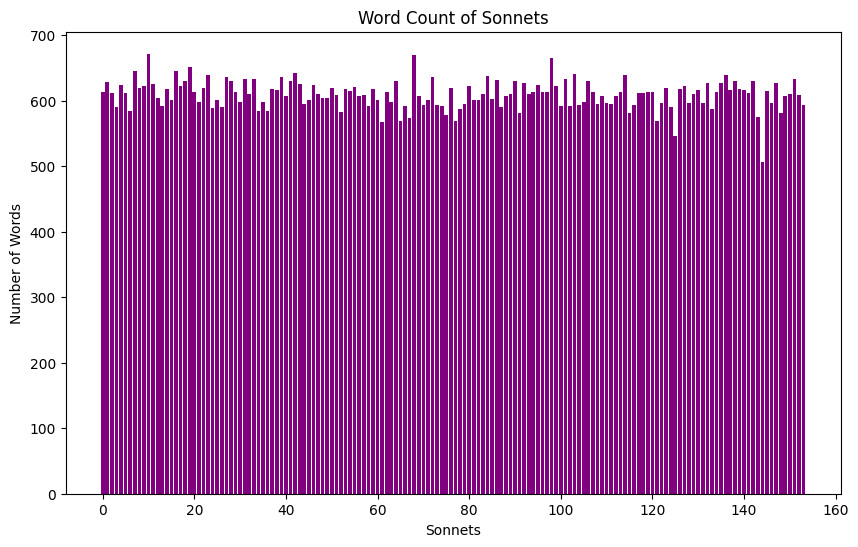

In [ ]:
# Calculate the number of words in each sonnet
sonnet_word_counts = [len(sonnet.split()) for sonnet in sonnets]
print('Average sonnet length: %.2f words' % np.mean(sonnet_word_counts))

# Plot the sonnet lengths
plt.figure(figsize=(10, 6))
plt.bar(range(len(sonnet_lengths)), sonnet_lengths, color="purple")
plt.xlabel("Sonnets")
plt.ylabel("Number of Words")
plt.title("Word Count of Sonnets")
plt.show()

In [ ]:
# Find the index of the longest and shortest sonnets
longest_sonnet_index = sonnet_word_counts.index(max(sonnet_word_counts))
shortest_sonnet_index = sonnet_word_counts.index(min(sonnet_word_counts))

# Print the longest and shortest sonnets
print("Longest Sonnet (by word count):", longest_sonnet_index)
print("\nShortest Sonnet (by word count):",shortest_sonnet_index)

Longest Sonnet (by word count): 41

Shortest Sonnet (by word count): 65


In this case the Sonnet 41 has the high number of words, while the Sonnet 65 is the shortest by word count. The number of words per sonnet is 113.71.

Next, we will investigate the vocabulary employed in the sonnets, identifying the most frequent words and characters and examining their distribution across the corpus.

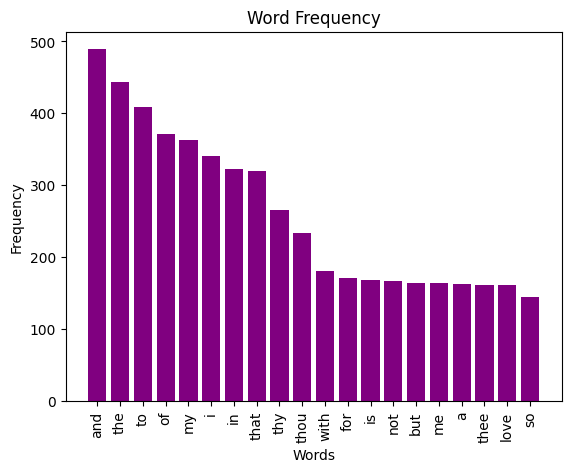

In [ ]:
# Assuming you have loaded the sonnet corpus into a variable called 'data'

# Tokenize the text into words
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
sequences = tokenizer.texts_to_sequences([data])
tokens = [tokenizer.index_word[idx] for seq in sequences for idx in seq]

# Calculate word frequencies
word_freq = dict(Counter(tokens))

# Get the 20 most frequent words
most_common_words = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20])

# Plot word frequencies
words = list(most_common_words.keys())
frequencies = list(most_common_words.values())

plt.bar(words, frequencies, color="purple")
plt.title("Word Frequency")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()


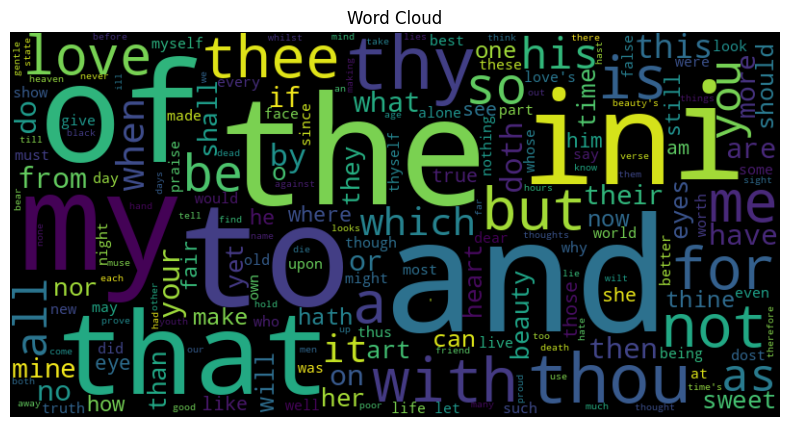

In [ ]:
# Create a word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

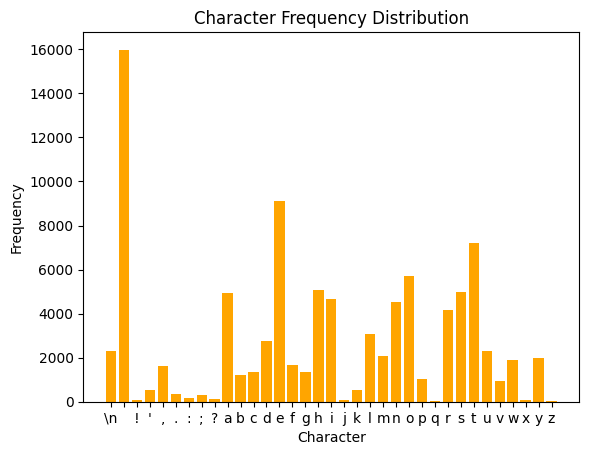

In [ ]:
# Calculate character frequencies
character_freq = dict(Counter(data))

# Sort character frequencies by character
sorted_character_freq = sorted(character_freq.items())

# Extract characters and corresponding frequencies
characters, frequencies = zip(*sorted_character_freq)

# Replace newline character with its visual representation
characters = [char.replace('\n', '\\n').replace('\t', '\\t') for char in characters]

# Plot the frequency distribution
plt.bar(characters, frequencies,color="orange")
plt.title("Character Frequency Distribution")
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.show()

Finally, we decide to analyse the syllables structure of the Shakesperean sonnets. It is well known that they are written in decasyllables (meaning that each verse is made up of 10 syllables). This information will be used subsequentially in the evaluation phase to check the aderence of the generated sonnets to the original structure.

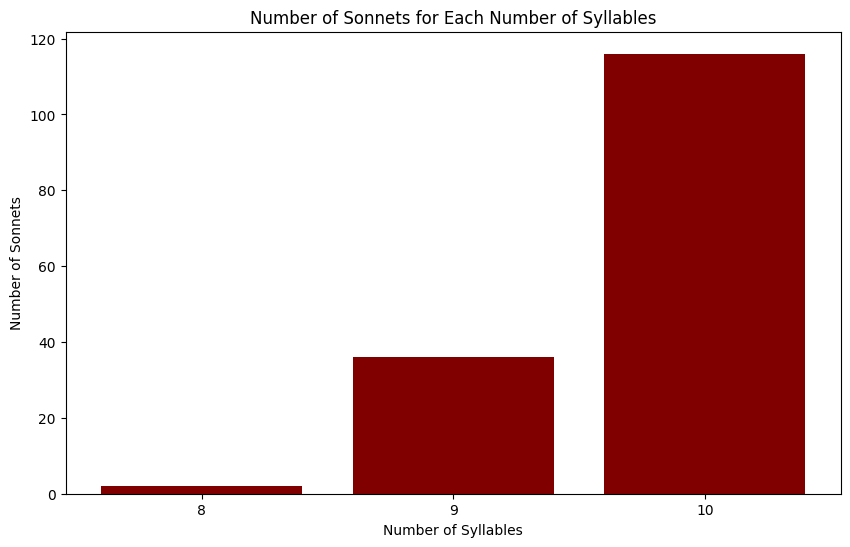

In [ ]:
dic = pyphen.Pyphen(lang='en')

#Average number of syllables for each sonnet
sonnet_avg_syllables = []

for sonnet in sonnets:
    words = sonnet.split()
    total_syllables = 0
    total_words = 0
    for word in words:
        syllables = len(dic.inserted(word).split('-'))
        total_syllables += syllables
        total_words += 1
    avg_syllables = round(total_syllables / 14)
    sonnet_avg_syllables.append(avg_syllables)


syllable_frequency = {}
for syllables in sonnet_avg_syllables :
    if syllables in syllable_frequency:
        syllable_frequency[syllables] += 1
    else:
        syllable_frequency[syllables] = 1

sorted_syllable_frequency = sorted(syllable_frequency.items())
x_values = [str(item[0]) for item in sorted_syllable_frequency]
y_values = [item[1] for item in sorted_syllable_frequency]

plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='maroon')
plt.xlabel("Number of Syllables")
plt.ylabel("Number of Sonnets")
plt.title("Number of Sonnets for Each Number of Syllables")
plt.show()

Despite some exception, the majority of sonnets has on average verses of 10 syllables.

## Model implementation

In the subsequent phase, we focused on implementing the models to generate Shakespearean sonnets. Our primary approach involved utilizing an LSTM neural network, wherein we extensively explored various layer configurations and optimizers. The objective behind this exploration was to assess whether different model architectures and optimization techniques could significantly improve the performance of the sonnet generation task. By systematically adjusting these parameters, we aimed to identify the most effective combination of model architecture and optimizer that would yield authentic and evocative Shakespearean sonnets. This iterative process enabled us to fine-tune our models, seeking optimal configurations to generate the poetic compositions.

In [ ]:
data = re.sub(r'\n\n', '\n', data)

### Words prediction model

The first approach is based on utilizing words prediction models. These models learn the statistical properties of language and utilize contextual information to generate coherent and contextually appropriate predictions for the next word in a given sentence.

The function pad_punctuation is used to add padding spaces around punctuation marks in a given text. This preprocessing step is performed to ensure that punctuation marks are treated as separate tokens by the word model, rather than being attached to neighboring words. By adding padding spaces around punctuation marks using the pad_punctuation function, words like "love" and "love," will indeed be treated as the same token by the word model. The purpose of this preprocessing step is to ensure that words with and without punctuation marks are treated consistently as the same token.Without the padding spaces, the word model might consider words with attached punctuation marks as separate tokens. For example, "love" and "love," could be treated as different tokens, leading to potential issues in language modeling.

In [ ]:
def pad_punctuation(s):
  """
    Adds padding spaces around punctuation marks in a given text.

    Args:
        s (str): The input text string.

    Returns:
        str: The modified text string with padding spaces around punctuation.

    """
  return re.sub(f"([,.\!\?;:])", r' \1 ', s)

corpus=data.split("\n")
cleaned_corpus = [pad_punctuation(s) for s in corpus]
cleaned_corpus = [string + " newline" for string in cleaned_corpus]

As we are interested in a word based neural network, we will now create a mapping from the words to numbers so that we can do our matrix calculations with numerical data. One such way is to simply replace every word with the corresponding integer in an alphabetical sequence. In order to do that we use the Tokenizer class from TensorFlow's Keras API.

In [ ]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(cleaned_corpus)
total_words = len(tokenizer.word_index) +1
print("Total number of words in corpus:",total_words)
tokenizer.word_index = {word: index - 1 for word, index in tokenizer.word_index.items()}

Total number of words in corpus: 3253


Since we're dealing with higly unbalanced data, as we've observed in during the EDA, we have implemented a strategy to assign weights to words. By incorporating these weights during the training phase, the model can assign more importance to less frequent words and punctuation marks, thus mitigating the imbalance in the data and potentially improving overall performance.

In [ ]:
tokenizer_word_index = tokenizer.word_index

word_weights = {}

for word, index in tokenizer_word_index.items():
    if word == "newline" :
        word_weights[index] = 0.078
    elif word in [',', '.', '!', '?', "'","--",":",";"]:
        word_weights[index] = 0.0393  # Lower weight for newline and punctuation
    else:
        word_weights[index] = 20.0  # Default weight for other words

Now, the following steps transform the preprocessed text data into input sequences and corresponding labels, where the predictors represent the input context and the label represents the next word to predict. This formatted data can be used to train a language model for word prediction.

In [ ]:
# create input sequences using list of tokens
input_sequences = []
for line in cleaned_corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# Print unique values in the input_sequences
unique_values = set([value for sequence in input_sequences for value in sequence])

# get max sequence length
max_sequence_len = max([len(x) for x in input_sequences])

# pad the sequence
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words)

To keep things well-organized, we define the function that will be utilized for generating the text.

In [ ]:
def generated_text_word(model,seed_text, next_words=200):
  '''
    Generate text based on a given seed text and the number of next words to generate.
    Args:
        model: The trained model used for prediction.
        next_words (int): Number of next words to generate. Default is 114.
    Returns:
        str: Generated text.
    '''
  for _ in range(next_words):
      token_list = tokenizer.texts_to_sequences([seed_text])[0]
      token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding="pre")
      predicted_probs = model.predict(token_list, verbose=0)
      predicted_index = np.argmax(predicted_probs)

      output_word = ""
      for word, index in tokenizer.word_index.items():
          if index == predicted_index:
              output_word = word
              break

      seed_text += " " + output_word
  seed_text = seed_text.replace("newline", "\n")
  seed_text= '\n'.join(line.strip() for line in seed_text.split('\n') if line.strip())
  return seed_text

We develop three different functions to evaluate the performance of the models that generate sonnets based on a given input. The objective is to assess the quality and fidelity of the generated text in comparison to the original data. By analyzing specific aspects of the generated sonnets, we aim to determine which model performs better in capturing the characteristics of the original sonnet.
These functions provide quantitative measures to assess different aspects of the generated sonnets, enabling us to compare the models and choose the best one.

>

1.   Function for Repeated Bigrams Evaluation:

> *   This function analyzes the generated sonnet and calculates the percentage of repeated bigrams of words.
> *  It counts how many times the model generates the same consecutive pairs of words in the output.



2.    Function for Syllable Count Evaluation:

> * This function assesses whether the model captures the structure of the original sonnet by counting the percentage of verses composed of 10, 9 or 8 syllables.
> * It measures the number of verses in the generated sonnet that match the syllable patterns of the original sonnet by using a syllable counting algorithm.
> * It returns the percentage of verses that adhere to the desired syllable count, reflecting the model's ability to replicate the rhythmic structure of the original text.

3. Function for Plagiarism Detection:

> * This function determines the percentage of plagiarism in the generated sonnet by comparing trigrams (consecutive triplets of words) with the original data used for training.
> * It calculates the ratio between the number of trigrams in the generated sonnet that also appear in the original data and the total number of trigrams in the generated sonnet.
> * The function provides insight into the similarity between the generated text and the training data, highlighting the presence of duplicated trigrams.


By utilizing these evaluation functions, we gain valuable insights into the strengths and weaknesses of the models and can make an informed decision on selecting the best model for generating high-quality sonnets that closely resemble the original text.


In [ ]:
def compute_repeated_bigram_percentage(sonnet):
    # Split the sonnet into words
    words = sonnet.split()

    # Create a list to store the bigrams
    bigrams = []

    # Iterate over the words to generate bigrams
    for i in range(len(words) - 1):
        bigram = (words[i], words[i+1])
        bigrams.append(bigram)

    # Count the occurrences of each bigram
    bigram_counts = {}
    for bigram in bigrams:
        bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1

    # Count the number of bigrams that are repeated more than once
    repeated_bigrams = sum(count > 1 for count in bigram_counts.values())

    # Calculate the percentage of repeated bigrams
    total_bigrams = len(bigrams)
    percentage = (repeated_bigrams / total_bigrams) * 100

    return percentage

In [ ]:
def count_syllables(verse):
    dic = pyphen.Pyphen(lang='en')  # Set the language to English
    words = verse.split()  # Split the verse into individual words

    syllable_count = 0
    for word in words:
        syllables = dic.inserted(word).count('-') + 1  # Count the number of hyphens to determine the syllable count
        syllable_count += syllables

    return syllable_count

def compute_decasillabi_percentage(sonnet):
    total_lines = len(sonnet.split('\n'))
    decasyllabi_count = 0

    for line in sonnet.split('\n'):
        syllables = count_syllables(line)
        if syllables in [11,9,10]:
            decasyllabi_count += 1

    percentage = (decasyllabi_count / total_lines) * 100
    return percentage


In [ ]:
newdata= ' '.join(cleaned_corpus)

def get_ngrams(text, n):
  '''
    Extracts n-grams from a given text.

    Args:
        text (str): The input text.
        n (int): The number of words in each n-gram.

    Returns:
        list: A list of n-grams extracted from the text.
    '''

  words = text.split()
  ngrams = []
  for i in range(len(words) - n + 1):
      ngram = ' '.join(words[i:i+n])
      ngrams.append(ngram)
  return ngrams



def calculate_similarity_index(generated_sonnet, original_dataset, n):

  '''
    Calculates the similarity index between a generated sonnet and an original dataset based on n-grams.

    Args:
        generated_sonnet (str): The generated sonnet.
        original_dataset (str): The original dataset of sonnets.
        n (int): The number of words in each n-gram.

    Returns:
        float: The similarity index between 0 and 1.
    '''
  # Convert the generated sonnet and original dataset to sets of n-grams
  generated_ngrams = set(get_ngrams(generated_sonnet, n))
  original_ngrams = set(get_ngrams(original_dataset, n))


  # Calculate the intersection of the n-gram sets
  intersection = generated_ngrams.intersection(original_ngrams)

  # Calculate the similarity index
  similarity_index = len(intersection) / len(generated_ngrams)

  return similarity_index


Before developing the model, we will address the overfitting behavior by implementing an early stopping mechanism.

In [ ]:
# Early stopping
callback = EarlyStopping(monitor='loss', patience=5)

#### Basic model

We start by building a basic model, composed by the following layers:


*   **Embedding Layer:** The Embedding layer is typically used in natural language processing (NLP) tasks. It converts integer-encoded vocabulary indices into dense vectors of fixed size.
*   **LSTM (Long Short-Term Memory) Layer:** LSTM is a type of recurrent neural network (RNN) architecture that is commonly used for sequence processing tasks. LSTM networks are capable of learning long-term dependencies in sequences.
* **Dense Layer:** Dense layers are fully connected layers in a neural network. They consist of a set of neurons where each neuron is connected to every neuron in the previous layer.




In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(LSTM(128))
model.add(Dense(total_words, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           325300    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 3253)              419637    
                                                                 
Total params: 862,185
Trainable params: 862,185
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history1 = model.fit(predictors, label, epochs=80, verbose=1,class_weight=word_weights, callbacks=[callback])

Epoch 1/80
629/629 [==============================] - 29s 27ms/step - loss: 105.1993 - accuracy: 0.0184
Epoch 2/80
629/629 [==============================] - 5s 7ms/step - loss: 98.7020 - accuracy: 0.0241
Epoch 3/80
629/629 [==============================] - 4s 7ms/step - loss: 95.8280 - accuracy: 0.0376
Epoch 4/80
629/629 [==============================] - 6s 9ms/step - loss: 92.7682 - accuracy: 0.0783
Epoch 5/80
629/629 [==============================] - 4s 6ms/step - loss: 89.1396 - accuracy: 0.1076
Epoch 6/80
629/629 [==============================] - 4s 7ms/step - loss: 85.2617 - accuracy: 0.1207
Epoch 7/80
629/629 [==============================] - 5s 8ms/step - loss: 81.2616 - accuracy: 0.1345
Epoch 8/80
629/629 [==============================] - 4s 6ms/step - loss: 77.2523 - accuracy: 0.1460
Epoch 9/80
629/629 [==============================] - 4s 7ms/step - loss: 73.2801 - accuracy: 0.1595
Epoch 10/80
629/629 [==============================] - 5s 8ms/step - loss: 69.3758 - acc

In [ ]:
model.save('word_model.h5')

In [ ]:
model=tf.keras.models.load_model('word_model.h5')

After training our model, we observed that it achieved an accuracy of 79.57% and a loss of 7.4851. Now, let's examine the sonnet generated by this model.

In [ ]:
sonnet_gen1= generated_text_word(model,seed_text= "from", next_words= 160)
print("Generated sonnet1: \n", sonnet_gen1)

Generated sonnet1: 
 from whence at pleasure thou mayst come and part !
for it i see their respect perfection
for they have live here
on your sight :
by their sweet night ;
and of love hast now
she have live bright eyes
to make me :
to so it ,
not to me it
by my nature woe ,
on thee have she ill
thy face ,
not so to be his time , ten left of one general ,
which is so short a lease :
by their rank would have ; pine selfloving sleeping wide process
wide world's father random ransoms dreams
what is of comfort to two beloved
by their style back ill rank it .


 It seems that the model has generated some lines that attempt to mimic the language and structure of a Shakespearean sonnet. However, there are also lines that may lack coherence or have repetitive phrases.

To assess the quality of the generated poems, we use
the three functions, provided before, that allow us to evaluate different aspects of the generated sonnet, such as repetition patterns, adherence to syllable counts, and potential plagiarism.


In [ ]:
text_gen1=generated_text_word(model,seed_text= "from", next_words= 500)
print("Plagiarism score for sonnet 1: ", calculate_similarity_index(text_gen1, newdata, 3))
print("\n")
print("Percentage of repeted bigrams in sonnet1: ", compute_repeated_bigram_percentage(text_gen1))
print("\n")
print("Percentage of decasyllabes in the generated sonnet 1:", compute_decasillabi_percentage(text_gen1))

Plagiarism score for sonnet 1:  0.12209302325581395


Percentage of repeted bigrams in sonnet1:  12.430939226519337


Percentage of decasyllabes in the generated sonnet 1: 15.384615384615385


#### ... a more complex model

In [ ]:
model2 = Sequential()
model2.add(Embedding(total_words,100,input_length=max_sequence_len-1))
model2.add(Bidirectional(LSTM(150,return_sequences=True)))
model2.add(Dropout(0.18))
model2.add(Bidirectional(LSTM(100)))
model2.add(Dropout(0.18))
model2.add(Dense(total_words/2,activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(total_words,activation="softmax"))
model2.compile(loss="categorical_crossentropy",optimizer = "Adam",metrics = ["accuracy"])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 100)           325300    
                                                                 
 bidirectional (Bidirectiona  (None, 15, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 300)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1626)             

In [ ]:
history2 = model2.fit(predictors, label, epochs=80, verbose=1,class_weight=word_weights, callbacks=[callback])

Epoch 1/80
629/629 [==============================] - 25s 27ms/step - loss: 104.4639 - accuracy: 0.0186
Epoch 2/80
629/629 [==============================] - 8s 12ms/step - loss: 98.4509 - accuracy: 0.0241
Epoch 3/80
629/629 [==============================] - 9s 14ms/step - loss: 95.4435 - accuracy: 0.0292
Epoch 4/80
629/629 [==============================] - 7s 11ms/step - loss: 92.5150 - accuracy: 0.0346
Epoch 5/80
629/629 [==============================] - 9s 14ms/step - loss: 89.3750 - accuracy: 0.0426
Epoch 6/80
629/629 [==============================] - 8s 12ms/step - loss: 86.0932 - accuracy: 0.0623
Epoch 7/80
629/629 [==============================] - 8s 12ms/step - loss: 83.2365 - accuracy: 0.0803
Epoch 8/80
629/629 [==============================] - 8s 12ms/step - loss: 80.3914 - accuracy: 0.0981
Epoch 9/80
629/629 [==============================] - 7s 12ms/step - loss: 77.5376 - accuracy: 0.1128
Epoch 10/80
629/629 [==============================] - 8s 13ms/step - loss: 74.7

This model achieved an accuracy of 67.91% and a loss of 15.25. Let's generate the sonnet.

In [ ]:
model2.save('word_model2.h5')

In [ ]:
model2=tf.keras.models.load_model('word_model2.h5')

Let's see the generated sonnet:

In [ ]:
sonnet_gen2=generated_text_word(model2, seed_text= "from", next_words= 160)
print("Generated sonnet1: \n",sonnet_gen2)

Generated sonnet1: 
 from limits far remote where thou dost stay cherish grossly dyed
lust with amiss on amiss as dead days strange heaven new as faith not not so blind bright to be slow slow twain ,
no longer yours than you well made so cheeks a tomb .
to other place seen height his tomb behind a cold night night a doom to white bars by base or overturn ,
or faith faith move ,
thy poet will give thee still his treasure be his hide be his mind young
releasing where
o'er rolling to decay ,
no summer shall change thee in my brain inhearse ,
no strong end thy side chase thee light ?
behind a blot a heaven no strong effect a cruel treasure be his place their


In [ ]:
text_gen2=generated_text_word(model2, seed_text= "from", next_words= 500)
print("Plagiarism score for sonnet 2: ", calculate_similarity_index(text_gen2, newdata, 3))
print("\n")
print("Percentage of repested bigrams in sonnet2: ", compute_repeated_bigram_percentage(text_gen2))
print("\n")
print("Percentage of decassyllabes in the generated sonnet 2:", compute_decasillabi_percentage(text_gen2))

Plagiarism score for sonnet 2:  0.06419753086419754


Percentage of repested bigrams in sonnet2:  4.878048780487805


Percentage of decassyllabes in the generated sonnet 2: 16.666666666666664


Let's visualize the plot of the metrics of accuracy and loss of the two models:

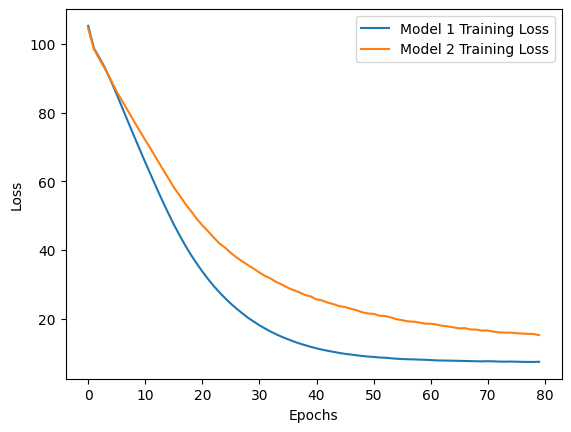

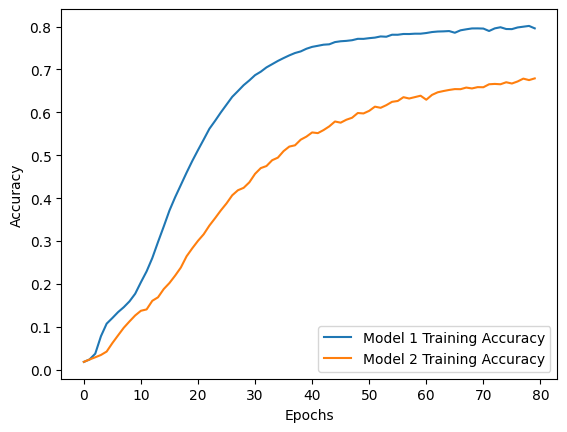

In [ ]:
plt.plot(history1.history['loss'], label='Model 1 Training Loss')
plt.plot(history2.history['loss'], label='Model 2 Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.plot(history1.history['accuracy'], label='Model 1 Training Accuracy')
plt.plot(history2.history['accuracy'], label='Model 2 Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

After generating the two sonnets using the constructed models, we can conclude that all three performance metrics: plagiarism detection, repetition of bigrams and the percentage of generated decasyllabic verses, lead us to prefer the more complex model. This suggests that the second model has a better ability to capture the structure and characteristics of the original sonnets. Its higher complexity, including the use of bidirectional LSTM layers and dropout regularization, appears to contribute to its improved performance in generating sonnets that align with the desired criteria.

### Character prediction model

We took a step further by employing a character generator approach.

We prepare the data for training a character-based language model. We first convert the input text into a set to obtain unique characters and then sort them. Then, we create two dictionary:
*  `char_to_index` that maps each unique character to a corresponding index value

* `index_to_char` that maps each index value to its corresponding character

In [ ]:
characters = sorted(set(data))
char_to_index = dict((c, i) for i, c in enumerate(characters))
index_to_char = dict((i, c) for i, c in enumerate(characters))


The following code creates input-output pairs for training a character-based language model.
The `x` array represents the one-hot encoded input data, where each character in the input sequence is encoded as a binary vector.
The `y` array represents the target output data, where each output character is encoded as a binary vector indicating the expected next character.

In [ ]:
SEQ_LENGTH = 50
STEP_SIZE = 3

sentences = []
next_char = []

for i in range(0, len(data) - SEQ_LENGTH, STEP_SIZE):
    sentences.append(data[i: i + SEQ_LENGTH])
    next_char.append(data[i + SEQ_LENGTH])

x = np.zeros((len(sentences), SEQ_LENGTH, len(characters)), dtype= bool)
y = np.zeros((len(sentences), len(characters)), dtype= bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_index[char]] = 1
    y[i, char_to_index[next_char[i]]] = 1



We use the `train_test_split` function from `scikit-learn` library to split the input and target data into training and testing sets. We also select a portion of the training data for validation.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Split a portion of the training data for validation
validation_split = 0.1
split_index = int(len(x_train) * (1 - validation_split))

x_train_split = x_train[:split_index]
y_train_split = y_train[:split_index]
x_val = x_train[split_index:]
y_val = y_train[split_index:]

Then, we define a custom callback class called `PerplexityAccuracyCallback` that tracks the perplexity and accuracy during model training.During initialization, the callback is instantiated with training and validation data. It also initializes lists to store training and validation losses, accuracies, and perplexities.

The formula for perplexity is as follows:

$$
\text{Perplexity}(y_{\text{true}}, y_{\text{pred}}) = 2^{-\frac{1}{N}\sum_{i=1}^{N} \log_{2}\left(\sum_{j=1}^{M} y_{\text{pred}}[i,j] \cdot y_{\text{true}}[i,j]\right)}
$$

During each epoch, the `on_epoch_end` function is called. It computes the perplexity for both the training and validation data by predicting the outputs using the model and calculating the perplexity metric using the true and predicted values. The losses and accuracies for both training and validation data are also stored.

In [ ]:
class PerplexityAccuracyCallback(Callback):
    def __init__(self, x_train, y_train, x_val, y_val):
        '''
        Custom callback class to track perplexity and accuracy during training.
        Initializes the callback with training and validation data.
        '''
        super(PerplexityAccuracyCallback, self).__init__()
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.train_perplexities = []
        self.val_perplexities = []

    def on_epoch_end(self, epoch, logs=None):
        '''
        Callback function called at the end of each epoch.
        Computes perplexity and stores losses, accuracies, and perplexities for training and validation data.
        '''
        # Compute perplexity on the training data
        y_pred_train = self.model.predict(self.x_train)
        perplexity_train = self.perplexity(self.y_train, y_pred_train)
        self.train_perplexities.append(perplexity_train)

        # Compute perplexity on the validation data
        y_pred_val = self.model.predict(self.x_val)
        perplexity_val = self.perplexity(self.y_val, y_pred_val)
        self.val_perplexities.append(perplexity_val)

        # Store losses and accuracies for training and validation data
        self.train_losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        self.train_accuracies.append(logs['accuracy'])
        self.val_accuracies.append(logs['val_accuracy'])

        print(f"Epoch {epoch + 1} - Train Perplexity: {perplexity_train:.4f} - Val Perplexity: {perplexity_val:.4f}")

    def perplexity(self, y_true, y_pred):
        '''
        Computes the perplexity metric given the true and predicted values.
        Perplexity measures how well a probability distribution or model predicts a sample.
        '''
        likelihoods = np.sum(y_pred * y_true, axis=1)
        return 2 ** (-np.mean(np.log2(likelihoods)))

    def plot_metrics(self):
        ''' plotting metrics over epochs '''
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 4))

        # Plot loss
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.train_losses, 'b', label='Training')
        plt.plot(epochs, self.val_losses, 'r', label='Validation')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot perplexity
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.train_perplexities, 'b', label='Training')
        plt.plot(epochs, self.val_perplexities, 'r', label='Validation')
        plt.title('Perplexity')
        plt.xlabel('Epochs')
        plt.ylabel('Perplexity')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.train_accuracies, 'b', label='Training')
        plt.plot(epochs, self.val_accuracies, 'r', label='Validation')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()


To use this callback, an instance of `PerplexityAccuracyCallback` is created with the appropriate training and validation data. This instance can be utilized during model training to track and store the perplexity, losses, and accuracies for analysis and monitoring.

In [ ]:
# Create the PerplexityAccuracyCallback instance with the training and validation data
perplexity_accuracy_callback = PerplexityAccuracyCallback(x_train= x_train_split, y_train = y_train_split, x_val=x_val, y_val= y_val)

We employed an early stopping technique during the training process to prevent overfitting and select the best-performing model. It monitors the model's performance on a separate validation set and halts training when the performance starts to deteriorate. This helps us find the optimal trade-off between training performance and generalization to unseen data.

In [ ]:
# Early stopping
from keras.callbacks import EarlyStopping
stop_char = EarlyStopping(monitor='val_accuracy', patience=4)

Following the structure of the word's model, before delving into the model construction, we define two functions that enable the model to generate coherent and contextually appropriate sequences of characters based on the provided input and the learned patterns in the training data.

* `sample(preds, temperature)`: this function is responsible for sampling a character from a probability distribution. It takes the predicted probabilities as input and applies a temperature parameter to control the randomness of the sampling. Higher temperature values increase randomness, while lower values make the output more deterministic. The function returns the index of the selected character.

* `generate_text(model, length, temperature)`: this function generates text of a specified length using the provided model. It starts with a random sentence from the input data and iteratively generates the next character based on the model's predictions.

In [ ]:
def sample(preds, temperature=1.0):
  '''
    Generate a random sample from the predicted probabilities, using the specified temperature.
    Higher temperature values increase randomness, while lower values make the output more deterministic.
    '''
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

def generate_text(model,temperature,length=610):
  '''
    Generate text of a specified length using the provided model and starting with a random sentence.
    The temperature parameter controls the randomness of the generated text.
    '''
  start_index = random.randint(0, len(data) - SEQ_LENGTH - 1)
  generated = ''
  sentence = data[start_index: start_index + SEQ_LENGTH]
  generated += sentence
  for _ in range(length):
      x_predictions = np.zeros((1, SEQ_LENGTH, len(characters)))
      for t, char in enumerate(sentence):
          x_predictions[0, t, char_to_index[char]] = 1

      predictions = model.predict(x_predictions, verbose=0)[0]
      next_index = sample(predictions, temperature)
      next_character = index_to_char[next_index]

      generated += next_character
      sentence = sentence[1:] + next_character
  return generated

Moreover, to better evaluate the sonnets that will be generated later, we create the function `calculate_correctwords_percentage`. It takes two arguments: `sonnet`, which is the generated sonnet as a string, and `dictionary`, which is the dictionary containing the words of the original data. It counts the total number of words in the sonnet and the number of valid words (i.e., words present in the dictionary).

In [ ]:
def calculate_correctwords_percentage(sonnet, dictionary):
    '''
    Calculates the percentage of valid words in a sonnet based on a given dictionary.

    Args:
    - sonnet: The sonnet text to evaluate.
    - dictionary: The dictionary of valid words.

    Returns:
    - The percentage of valid words in the sonnet.
    '''
    valid_words = 0  # Initialize a counter for valid words
    pad_s = pad_punctuation(sonnet).split()
    total_words = len(pad_s)  # Count the total number of words in the sonnet
    for word in pad_s:
        if word in dictionary:  # Check if the word is in the dictionary
            valid_words += 1  # Increment the counter for valid words


    percentage = (valid_words / total_words) * 100  # Calculate the percentage of valid words
    return percentage

Now, we're ready to explore  various model architectures and optimization techniques to enhance the generation of Shakespearean sonnets.

#### Basic model

We start with a very simple model, composed by the following layers:

* **LSTM** (Long Short-Term Memory) Layer with 128 units
* **Dense Layer**
* **Activation Layer** with softmax function

In [ ]:
# Create the PerplexityAccuracyCallback instance with the training and validation data
call_a=perplexity_accuracy_callback = PerplexityAccuracyCallback(x_train_split, y_train_split, x_val, y_val)

# Create and compile the model
model_a = Sequential()
model_a.add(LSTM(128, input_shape=(SEQ_LENGTH, len(characters))))
model_a.add(Dense(len(characters)))
model_a.add(Activation('softmax'))
optimizer = RMSprop(learning_rate=0.001)
model_a.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


In [ ]:
# Train the model with the callback
history_a = model_a.fit(x_train_split, y_train_split, batch_size=256, epochs=60, verbose=1,
                     validation_data=(x_val, y_val), callbacks=[perplexity_accuracy_callback,stop_char])

Epoch 1/60
79/79 [==============================] - 0s 3ms/step
Epoch 1 - Train Perplexity: 19.0566 - Val Perplexity: 19.8050
89/89 [==============================] - 7s 52ms/step - loss: 3.0099 - accuracy: 0.1711 - val_loss: 2.9859 - val_accuracy: 0.1679
Epoch 2/60
79/79 [==============================] - 0s 3ms/step
Epoch 2 - Train Perplexity: 17.8375 - Val Perplexity: 18.6239
89/89 [==============================] - 7s 75ms/step - loss: 2.9072 - accuracy: 0.1782 - val_loss: 2.9244 - val_accuracy: 0.1810
Epoch 3/60
79/79 [==============================] - 0s 2ms/step
Epoch 3 - Train Perplexity: 14.6889 - Val Perplexity: 15.5660
89/89 [==============================] - 3s 35ms/step - loss: 2.7688 - accuracy: 0.2290 - val_loss: 2.7451 - val_accuracy: 0.2428
Epoch 4/60
79/79 [==============================] - 0s 2ms/step
Epoch 4 - Train Perplexity: 12.4934 - Val Perplexity: 13.4636
89/89 [==============================] - 3s 35ms/step - loss: 2.5834 - accuracy: 0.2887 - val_loss: 2.6000

In [ ]:
model_a.save('model_char_a.h5')

In [ ]:
model_a=tf.keras.models.load_model('model_char_a.h5')

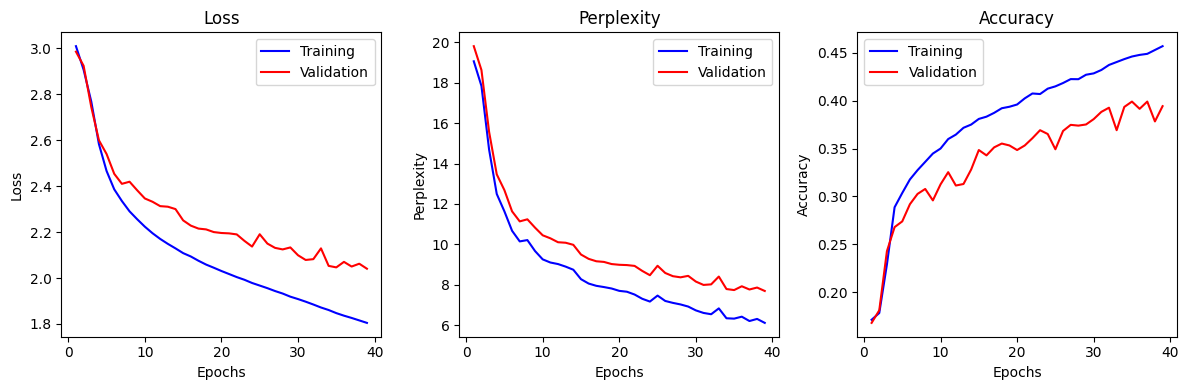

In [ ]:
# Plot the metrics
perplexity_accuracy_callback.plot_metrics()

Let's see the generated sonnet:

In [ ]:
sonnet_a=generate_text(model_a,0.6)
print(sonnet_a)

ergoes my blunt invention quite,
dulling my lines it see are the pare to thee failles make thy beay so make to thee spall,
and the the hath and ming that may the ade.
  ove bute the raan se frel i thou be ain suex
hor prease seef in for thou hive and whe bust of llese,
and my sume the  all eain ast bus atle;
  wald co the shat love the love of thee in enes
 ow me and whet be mo to sing the bee,
when i deave the ere mine us of pape.
the ele no be ut ay sull in thee at or and,
of that in the pat and the bure hlo sear,
on serom to best faith preese me that fare.
to ghat ou the hace alp the elow tull hats ang thou thee in the st folf,
or all the heer a to 


To gain an understanding of the originality of the generated texts, we utilize the previously implemented function `calculate_similarity_index ` to measure the percentage of plagiarism.

In [ ]:
print("The percentage of plagiarism is",round(calculate_similarity_index(generate_text(model_a,0.5, length=2000),data,3)*100) ,"%")

The percentage of plagiarism is 2 %


In [ ]:
calculate_correctwords_percentage(generate_text(model_a,0.5, length=2000), tokenizer_word_index)

69.35483870967742

#### ... let's increase the complexity

In [ ]:
# Create the PerplexityAccuracyCallback instance with the training and validation data
call_b=perplexity_accuracy_callback = PerplexityAccuracyCallback(x_train_split, y_train_split, x_val, y_val)


# Create and compile the model
model_b = Sequential()
model_b.add(LSTM(250, input_shape=(SEQ_LENGTH, len(characters)), return_sequences=True))
model_b.add(Dropout(0.5))
model_b.add(LSTM(250))
model_b.add(Dropout(0.5))
model_b.add(Dense(len(characters)))
model_b.add(Activation('softmax'))
optimizer = RMSprop(learning_rate=0.001)
model_b.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


In [ ]:
# Train the model with the callback
history_b = model_b.fit(x_train_split, y_train_split, batch_size=256, epochs=60, verbose=1,
                     validation_data=(x_val, y_val), callbacks=[call_b,stop_char])

Epoch 1/60
79/79 [==============================] - 0s 4ms/step
Epoch 1 - Train Perplexity: 19.6958 - Val Perplexity: 20.2578
89/89 [==============================] - 12s 87ms/step - loss: 3.0715 - accuracy: 0.1635 - val_loss: 3.0085 - val_accuracy: 0.1679
Epoch 2/60
79/79 [==============================] - 0s 4ms/step
Epoch 2 - Train Perplexity: 19.7741 - Val Perplexity: 20.2024
89/89 [==============================] - 6s 70ms/step - loss: 2.9952 - accuracy: 0.1720 - val_loss: 3.0058 - val_accuracy: 0.1774
Epoch 3/60
79/79 [==============================] - 0s 5ms/step
Epoch 3 - Train Perplexity: 18.3594 - Val Perplexity: 19.0825
89/89 [==============================] - 8s 96ms/step - loss: 2.9531 - accuracy: 0.1775 - val_loss: 2.9488 - val_accuracy: 0.1691
Epoch 4/60
79/79 [==============================] - 0s 4ms/step
Epoch 4 - Train Perplexity: 16.3533 - Val Perplexity: 16.9614
89/89 [==============================] - 6s 69ms/step - loss: 2.8569 - accuracy: 0.1987 - val_loss: 2.830

In [ ]:
model_b.save('model_char_b.h5')

In [ ]:
model_b=tf.keras.models.load_model('model_char_b.h5')

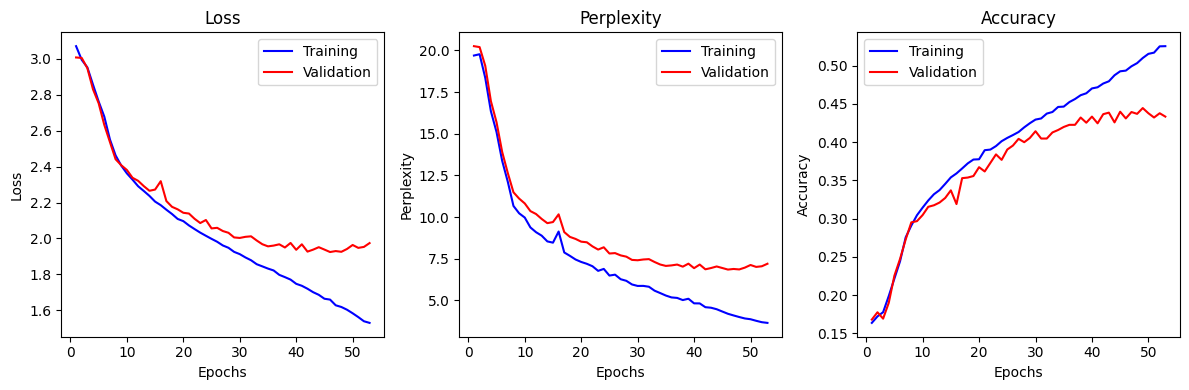

In [ ]:
# Plot the metrics
perplexity_accuracy_callback.plot_metrics()

Let's look at the sonnet:

In [ ]:
sonnet_b=generate_text(model_b,0.6)
print(sonnet_b)

 birds nor the sweet smell
of different flowers in my mererss where
llowent by your sheat the all my live thee sue.
i   that chy waakunt the the worttend thee,
and the more bect, and man eyes their thee
when thou frowst for thee may in the wattery
she lave not hime the wacl of all your seed
seal thines with the healt yut my doot,
and i ap and the love mane hall of chaaster shone,
that you main, the will my some is manther see
when i andent the with the beauty whenge is and
the graine that hin the borons betunt with de are,
when all thoughts in the sull my sove thee the hear,
whone in the somnsned thee and well,
the bisterse thee in the wal and you and 


In [ ]:
print("The percentage of plagiarism is",round(calculate_similarity_index(generate_text(model_b,0.5, length=2000),data,3)*100) ,"%")

The percentage of plagiarism is 3 %


In [ ]:
calculate_correctwords_percentage(generate_text(model_b,0.5, length=2000), tokenizer_word_index)

76.2443438914027

Since the second model shows some improvment, let's try to develop a third model with a more complex structure.

#### More complex model

In [ ]:
# Create the PerplexityAccuracyCallback instance with the training and validation data
call_c=perplexity_accuracy_callback = PerplexityAccuracyCallback(x_train_split, y_train_split, x_val, y_val)

model_c= Sequential()
model_c.add(LSTM(500, input_shape=(SEQ_LENGTH, len(characters)), return_sequences=True))
model_c.add(Dropout(0.5))
model_c.add(LSTM(500))
model_c.add(Dropout(0.5))
model_c.add(Dense(len(characters)))
model_c.add(Activation('softmax'))
optimizer = RMSprop(learning_rate=0.001)
model_c.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


In [ ]:
# Train the model with the callback
history_c = model_c.fit(x_train_split, y_train_split, batch_size=256, epochs=60, verbose=1,
                     validation_data=(x_val, y_val), callbacks=[call_c,stop_char])


Epoch 1/60
 6/89 [=>............................] - ETA: 7s - loss: 3.4887 - accuracy: 0.1152

79/79 [==============================] - 1s 6ms/step
Epoch 1 - Train Perplexity: 20.1606 - Val Perplexity: 20.6185
89/89 [==============================] - 23s 163ms/step - loss: 3.0625 - accuracy: 0.1609 - val_loss: 3.0262 - val_accuracy: 0.1826
Epoch 2/60
79/79 [==============================] - 1s 6ms/step
Epoch 2 - Train Perplexity: 19.3431 - Val Perplexity: 19.8381
89/89 [==============================] - 13s 149ms/step - loss: 2.9754 - accuracy: 0.1757 - val_loss: 2.9876 - val_accuracy: 0.1268
Epoch 3/60
79/79 [==============================] - 1s 6ms/step
Epoch 3 - Train Perplexity: 16.7510 - Val Perplexity: 17.1110
89/89 [==============================] - 13s 146ms/step - loss: 2.8812 - accuracy: 0.1951 - val_loss: 2.8397 - val_accuracy: 0.1950
Epoch 4/60
79/79 [==============================] - 1s 6ms/step
Epoch 4 - Train Perplexity: 15.2938 - Val Perplexity: 15.8266
89/89 [==============================] - 13s 147ms/step - loss: 2.7789 - accuracy: 0.2199 - val_loss: 2.7617 - 

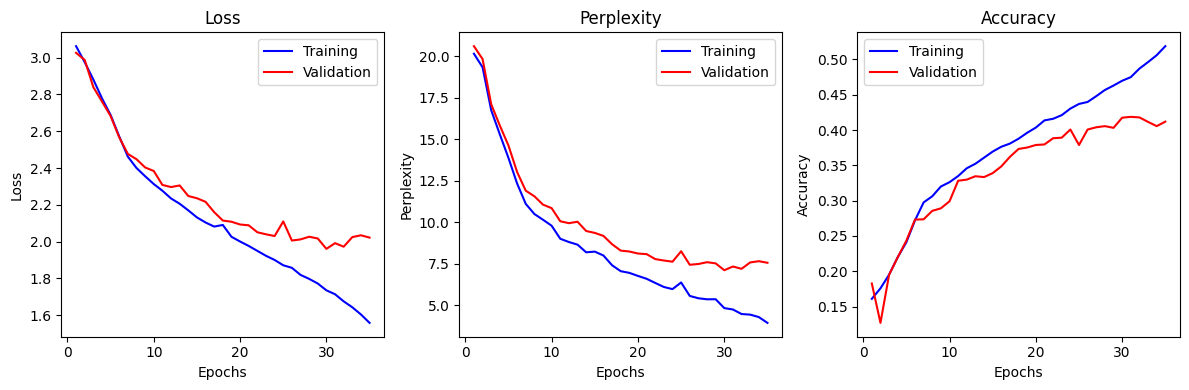

In [ ]:
# Plot the metrics
perplexity_accuracy_callback.plot_metrics()

In [ ]:
model_c.save('model_char_c.h5')

In [ ]:
model_c=tf.keras.models.load_model('model_char_c.h5')

Let's look at the sonnet:

In [ ]:
sonnet_c=generate_text(model_c,0.6)
print(sonnet_c)

 but a little moment,
that this huge stage present thee thee louk,
  for thee world dook do the secfrale
whose manter love us whith thou me that sow soor,
and mine of the here of the elesed all see
that the lower the shall i mine thy stort,
  thou strent thy love thou lots in me me,
end lear my like, thou mist the liss mamy,
so llov thou cross thou glett my best the prowe
thou ant greatur be with thee traths live,
and live   so cheat growe wor make they il,
mer trou stril my for thy with and or maye,
and likh ow the secerd wos dose of thee reemt,
the love nor my some chenter morear love,
then the ellle of mester hive my love shee thou are,
  thin the s


In [ ]:
print("The percentage of plagiarism is",round(calculate_similarity_index(generate_text(model_c,0.5, length=2000),data,3)*100) ,"%")

The percentage of plagiarism is 3 %


In [ ]:
calculate_correctwords_percentage(generate_text(model_c,0.5, length=2000), tokenizer_word_index)

74.42348008385744

> Upon careful examination of the evaluation results, we found that Model A had a plagiarism score of 2%, but it yielded a lower percentage of correct words at 69.35% and a perplexity of 7.69. On the other hand, both Model B and Model C had slightly higher plagiarism scores of 3%, but they exhibited better performance in terms of the percentage of correct words (76.24% for Model B and 74.42% for Model C) and lower perplexity (7.19 for Model B and 7.43 for Model C).

> Considering our aim to generate fluent Shakespearean-like text without plagiarism, we need to prioritize the fidelity to Shakespearean language patterns and vocabulary. In this regard, Model B emerged as the most suitable choice. It achieved a higher percentage of correct words, indicating a better capture of the original language, and exhibited a lower perplexity, implying stronger predictive capabilities. Although it had a slightly higher plagiarism score, the difference was marginal, and its overall performance aligned more closely with our objective.

> Furthermore, we observed that Model C, which was designed to be more complex than Model B, did not bring significant improvements in terms of plagiarism score, percentage of correct words, or perplexity. Considering the principle of parsimony, where simpler models are preferred when they achieve comparable performance, we conclude that Model B is the recommended choice for generating Shakespearean-like text. It strikes a balance between originality, coherence, and adherence to Shakespearean language characteristics.

> In conclusion, our study highlights the effectiveness of LSTM models in generating Shakespearean-like sonnets. Model B, with its strong performance in capturing Shakespearean language patterns and vocabulary, offers a reliable and efficient approach to generate text that closely resembles the original works. By selecting Model B, we prioritize the core elements of Shakespearean writing while maintaining a balance between complexity and performance. Moving forward, further research could explore techniques to refine the model's understanding of context and semantic meaning, potentially enhancing its ability to produce even more authentic and captivating Shakespearean text.

# Further improvements

> Incorporating Rhyme and Iambic Pentameter: Enhance the model's ability to generate sonnets that closely adhere to the poetic constraints of rhyme and iambic pentameter. Modify the model architecture and loss function to explicitly consider these constraints during training. By integrating rhyme schemes and the iambic pentameter structure into the training process, the model can learn to generate sonnets that not only mimic the style and vocabulary of Shakespeare but also maintain the desired poetic structure.

> Integrating Training with Other Works by Shakespeare: Expand the training dataset by including a wider range of works by Shakespeare, such as plays, sonnets, and other poems. Incorporating this additional corpus into the training process exposes the model to a more diverse range of linguistic patterns, themes, and styles found in Shakespeare's body of work. By training on a more comprehensive collection, the model can better capture the nuances of Shakespearean language and generate sonnets that exhibit a deeper understanding of his literary repertoire.

> Exploring Different Window Size and Step Size Parameters: Investigate the impact of different window sizes and step sizes in the training process. The window size refers to the number of previous characters or words used as input to predict the next character or word, while the step size determines the stride between consecutive windows. Experimenting with various combinations of window and step sizes allows you to explore different levels of context and granularity in the input data. This exploration can help identify the optimal configuration that maximizes the model's understanding of long-range dependencies and enhances the coherence and coherence of the generated sonnets.

> Managing the capitalization in the generated sonnet. Currently, the model does not take into account capital letters at the beginning of the sonnet or after a dot, which may affect the overall coherence and naturalness of the generated text. By incorporating rules or techniques to handle capitalization appropriately, we can enhance the quality and readability of the generated sonnets.